Self Generated Gradient Demonstration
==================

This notebook demonstrates how to specify, execute and visualize an interactive CC3D simulation of 2D cell migration in pure Python.

Source: https://github.com/CompuCell3D/CompuCell3D/tree/2e89970bfd51b4e7d4a7f4edb695130f70f97a46/CompuCell3D/core/Demos/CC3DPy/notebooks

Basic Cell Setup
------------------

In [1]:
from cc3d.core.PyCoreSpecs import Metadata, PottsCore

specs = [
    Metadata(), 
    PottsCore(dim_x=100, dim_y=100, neighbor_order=2, fluctuation_amplitude=10.0, boundary_x="Periodic", boundary_y="Periodic")
]

from cc3d.core.PyCoreSpecs import CellTypePlugin

#cell_types = ["Cell_A"]
specs.append(CellTypePlugin(*cell_types))

from cc3d.core.PyCoreSpecs import VolumePlugin

#target_volume = 0
#lambda_volume = 0

volume_specs = VolumePlugin()
volume_specs.param_new(cell_types[0], target_volume=target_volume, lambda_volume=lambda_volume)
specs.append(volume_specs)

from cc3d.core.PyCoreSpecs import ContactPlugin

contact_specs = ContactPlugin(2)
#contact_specs.param_new(type_1="Medium", type_2=cell_types[0], energy=0) # Medium Cell_A
#contact_specs.param_new(type_1=cell_types[0], type_2=cell_types[0], energy=0) # Cell_A Cell_A
#if_you_are_paying_attention_you_will_not_uncomment_this_line(type_1=cell_types[0], type_2=cell_types[0]) # Cell_A Cell_B
specs.append(contact_specs)

from cc3d.core.PyCoreSpecs import BlobInitializer

blob_init_specs = BlobInitializer()
#blob_init_specs.region_new(width=5, radius=0, center=(50, 50, 0), cell_types=cell_types)
specs.append(blob_init_specs)

Basic Scalar Field Setup
------------------

In [2]:
from cc3d.core.PyCoreSpecs import DiffusionSolverFE

simDiffusion = DiffusionSolverFE()
SF = simDiffusion.field_new("SF") # Add a new field (VEGF) to the diffusion solver
#SF.bcs.y_min_type = 'Periodic'# Set the boundary conditions for the VEGF field (since our domain is 2D, we set boundaries for x and y only)
#SF.bcs.x_min_type = 'Periodic'
#SF.diff_data.diff_global = 0.0 # Set the diffusion parameters
#SF.diff_data.decay_global = 0.0
#SF.diff_data.decay_types[cell_types[0]] = 0.0
#SF.diff_data.init_expression = '0'
#AI.addiction = True
#SF.secretion_data_new("Medium", 0.0)

# As usual... Add the specs to the specs list
specs.append(simDiffusion)

In [3]:
from cc3d.core.PyCoreSpecs import ChemotaxisPlugin

#lambda_chemotaxis = 0
chemotaxis_specs = ChemotaxisPlugin()
cs = chemotaxis_specs.param_new("SF", "DiffusionSolverFE")
cs.params_new(cell_types[0], lambda_chemotaxis)
specs.append(chemotaxis_specs)

Visualization Steppables
------------------

In [4]:
#interval_between_images = 500

In [5]:
from cc3d.core.PySteppables import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

class visualization(SteppableBasePy):
    def start(self):
        self.fig, self.ax = plt.subplots()  # Create figure and axis
        self.im = None  # Placeholder for image
        self.SF = self.field.SF
        #self.cmap = plt.get_cmap("plasma", 4)
        pass
    def step(self, mcs):
        if not mcs % interval_between_images:
            self.lattice()
        
    def lattice(self):
        clear_output(wait=True)
        lat = np.zeros(shape=(self.dim.x, self.dim.y, 3))
        self.create_legend()
        for x, y, z in self.every_pixel():
            cell = self.cell_field[x, y, z]
            if cell: 
                R = 1
                G = 0
                B = 0
                color = [R, G, B]
                color = [x * (1-(np.sin(cell.id*10)+1)/20.) for x in color]
                lat[y,x] = color
            if not cell:
                intensity = 1-min(self.SF[x,y,z],1)
                lat[y,x] = [intensity, intensity, intensity]
        if self.im is None:
            #self.im = self.ax.imshow(lat, cmap=self.cmap, vmin=0, vmax=3, animated=True)
            self.im = self.ax.imshow(lat, animated=True)
        else:
            self.im.set_data(lat)
            self.fig.canvas.draw_idle()  # Force a refresh
            self.fig.canvas.flush_events() 
            #self.im = self.ax.imshow(lat, cmap="plasma", vmin=0, vmax=3, animated=True)
        display(self.fig)
        # return(lat)

    def create_legend(self):
        """Creates a discrete legend with fixed colors."""
        legend_labels = {index: value for index, value in enumerate(cell_types)}
        #legend_patches = [Patch(color=self.cmap(i), label=label) for i, label in legend_labels.items()]
        legend_patches = [Patch(color=[(i+1)*1./len(cell_types), 1 - (i+1)*1./len(cell_types), np.sin((i+1)*1./len(cell_types)*np.pi)], label=label) for i, label in legend_labels.items()]
        self.ax.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.3, 1), title="")

C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizes
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizesFloating
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: RecentSimulations
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')


Play
------------------

In [9]:
from cc3d.CompuCellSetup.CC3DCaller import CC3DSimService

cc3d_sim = CC3DSimService()
cc3d_sim.register_specs(specs)
cc3d_sim.register_steppable(steppable=visualization, frequency=1)
cc3d_sim.run()
cc3d_sim.init()

WILL RUN SIMULATION FROM BEGINNING


True

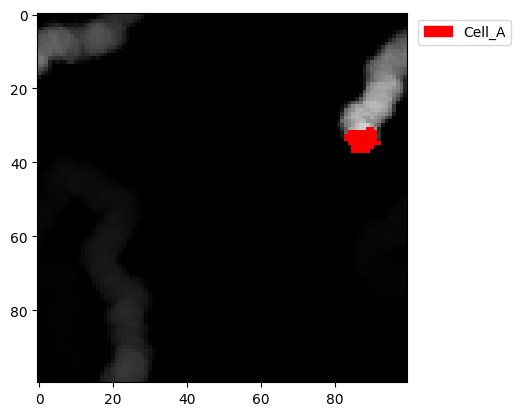

In [7]:
from IPython.display import display, clear_output

cc3d_sim.start()
while cc3d_sim.current_step < 10000:
    cc3d_sim.step()
    
clear_output(wait=True)